# Set up environment

In [289]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import division
from __future__ import print_function

# Load scipy/numpy/matplotlib
from   scipy.linalg import expm
import matplotlib.pyplot as plt
from   pylab import *

# Configure figure resolution
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['savefig.dpi'   ] = 100

from izh       import * # Routines for sampling Izhikevich neurons
from plot      import * # Misc. plotting routines
from glm       import * # GLM fitting
from arppglm   import * # Sampling and integration
from utilities import * # Other utilities
from arguments import * # Argument verification

import numpy as np
import scipy.io

dtype = 'float32'

import os
flags = 'mode=FAST_RUN,device=gpu,floatX=%s'%dtype

#flags = 'mode=fast_compile,device=gpu,floatX=%s'%dtype
if dtype!='float64':
    flags += ',warn_float64=warn'
print(flags)
os.environ["THEANO_FLAGS"] = flags
import theano
import theano.tensor as T

from warnings import warn

from theano.compile.nanguardmode import NanGuardMode
NANGUARD = NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True)

print('Workspace Initialized')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
mode=FAST_RUN,device=gpu,floatX=float32,warn_float64=warn
Workspace Initialized


### Theano helper functions

In [397]:
np.finfo('float32').eps

1.1920929e-07

In [402]:
np.log(np.sqrt(np.finfo('float32').max))

44.36142

In [404]:
def Tcon(x):
    return T.constant(x,dtype=dtype)

eps     = 1e-4#Tcon(np.finfo('float32').eps)
max_exp = Tcon(4)#Tcon(np.log(np.sqrt(np.finfo('float32').max)))

def nozero(x):
    '''Clip number to be larger than `eps`'''
    return T.maximum(eps,x)
    #return T.log(1+T.exp(x*10))/10

def Tslog(x):
    '''Theano safe logarithm'''
    return T.log(nozero(x))

def Tsexp(x):
    return T.exp(T.minimum(max_exp,x))

def Tsinv(x):
    return 1.0/nozero(x)

def Tsdiv(a,x):
    return a/nozero(x)

def Tfun(inp=None,out=None,upd=None):
    return theano.function(inputs               = inp,
                           outputs              = out,
                           updates              = upd,
                           on_unused_input      = 'warn',
                           allow_input_downcast = True)
#,
 #                          mode                 = NANGUARD)
    
print('Theano helper functions defined')

Theano helper functions defined


### Load saved features for GLM

In [298]:
saved_training_model = scipy.io.loadmat('saved_training_model.mat')
K  = np.array(saved_training_model['K'],dtype=dtype)
B  = np.array(saved_training_model['B'],dtype=dtype)
By = np.array(saved_training_model['By'],dtype=dtype)
Bh = np.array(saved_training_model['Bh'],dtype=dtype)
A  = np.array(saved_training_model['A'],dtype=dtype)
C  = np.array(saved_training_model['C'],dtype=dtype)
Y  = np.array(saved_training_model['Y'],dtype=dtype)
dt = np.array(saved_training_model['dt'],dtype=dtype)

K  = int(scalar(K))
N  = prod(Y.shape)
Y  = np.squeeze(Y)
X  = concatenate([By,Bh],axis=1)

# Don't use all training data
'''N  = 3000
Y  = Y[:N]
By = By[:N]
Bh = Bh[:N]
X  = X[:N]'''

STARTPLOT = 3000
NPLOT = 2500
Y  = Y[STARTPLOT:STARTPLOT+NPLOT]
By = By[STARTPLOT:STARTPLOT+NPLOT]
Bh = Bh[STARTPLOT:STARTPLOT+NPLOT]
X  = X[STARTPLOT:STARTPLOT+NPLOT]

N = len(X)
STARTPLOT=0
NPLOT=N

print('Saved GLM features loaded')

Saved GLM features loaded


### Fit GLM on CPU and verify that filtering approximates basis functions

In [299]:
def lograte(p):
    '''
    Log-intensity of point process model on this dataset
    Predicted using the standard GLM way
    '''
    m       = array(p).ravel()[0]
    beta    = ascolumn(p[1:K+1])
    beta_st = ascolumn(p[1+K:])
    lograte = m + Bh.dot(beta_st) + By.dot(beta)
    return lograte

def logmean(M1,p):
    '''
    Projected history process
    Predicted using history-process means
    '''
    m       = array(p).ravel()[0]
    beta    = ascolumn(p[1:K+1])
    beta_st = ascolumn(p[1+K:])
    M1      = np.squeeze(M1)
    return (beta.T.dot(M1.T))[0] + (m + Bh.dot(beta_st))[:,0]

def filter_GLM_np(p):
    m        = array(p).ravel()[0]
    beta     = ascolumn(p[1:K+1])
    beta_st  = ascolumn(p[1+K:])
    stim     = (m + Bh.dot(beta_st))[:,0]
    allM1_np = np.zeros((N,K))
    M1       = np.zeros((K,1))
    for i in range(N):
        R   = sexp(p0[1:K+1].dot(M1)+m+stim[i])
        M1 += A.dot(M1)*dt + C.dot(R)
        allM1_np[i] = M1[:,0]
    return allM1_np

def addspikes():
    for t in find(Y>0):
        axvline(t,color=OCHRE,lw=0.4)
    
def niceaxis():
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore",message='No labelled objects found')
        legend()
    simpleraxis()
    xlim(STARTPLOT,STARTPLOT+NPLOT)
    addspikes()

print('GLM helpers done')

GLM helpers done


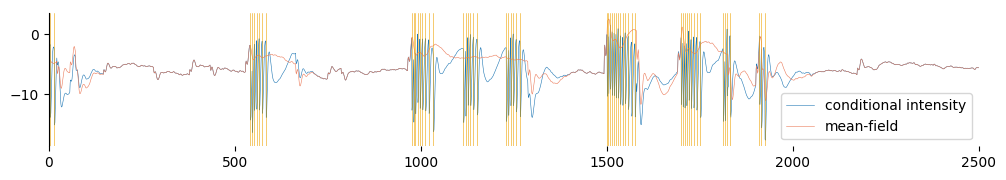

In [300]:
# Re-fit GLM
m,bhat  = fitGLM(X,Y)

# Re-pack model parameters
p0      = np.zeros((1+len(bhat)))
p0[0 ]  = m
p0[1:]  = bhat

allM1_np = filter_GLM_np(p0)

subplot(311)
plot(lograte(p0),lw=0.4,label='conditional intensity')
subplot(311)
plot(logmean(allM1_np,p0),lw=0.4,label='mean-field',color=RUST)
niceaxis()

# Fit GLM on Theano using mean-field

This will neglect conditional structure available in the data and focus on matching the slow-timescales with the mean-field limit of the GLM

We should adjust the negative-log-likelihood for best machine precision. It should be rescaled so that the initial guess has negative-log-likelihood of zero, and so that the gradient is steep enough so as not to suffer from precision loss. We will implement this with a scalar offset and gain for the negative log-likelihood, passed as parameters. 

In [308]:
# Input arguments
Xst  = T.matrix("Xst",dtype=dtype) # stimulus history features
Ysp  = T.vector("Ysp",dtype=dtype) # spikes
par  = T.vector("par",dtype=dtype) # packed parameter vectors

# Negative log-likelihood gain and offset to
# mitigate precision loss
llgain = T.scalar('llgain',dtype=dtype)
llbias = T.scalar('llbias',dtype=dtype)

# Cast A to theano consatn
Aop = Tcon(A)
Cop = Tcon(C)

# Unpack parameter vector
b    = par[1:K+1] # spike history weights
bst  = par[K+1:]  # stimulus weights
mm   = par[0]     # constant offset

# Pre-compute projected stimulus
# This evaluates to a vector
stim = mm + Xst.dot(bst)

# Hard-coded parameters
oversample   = 5
dt           = 1.0
maxrate      = Tcon(2)
maxlogr      = Tslog(maxrate)

# Constants
dtf = dt/oversample
Adt = Aop*dtf

# Initial condition for moments
# These should be theano variables as they will 
# need to be passedto initialize the scan function
M1 = Tcon(np.zeros((K,1)))
M2 = T.eye(K,dtype=dtype)*eps

def GLM_ll(y,s,M1):                  # scalar, scalar, column
    m      = b.T.dot(M1)             # b:vector, M1:column, result:len-1 vector
    logr   = T.minimum(maxlogr,m+s)  # 1 vector
    ll     = y*logr-Tsexp(logr)      # 1 vector
    return ll[0]                     # scalar

def integrate_GLM(M1,s):             # column, scalar
    for j in range(oversample):
        logx = b.T.dot(M1)+s         # 1 vector
        R0   = Tsexp(logx)           # 1 vector
        R0   = T.minimum(maxrate,R0) # 1 vector
        M1  += Cop*(R0*dtf)          # Kx1 matrix (column) spiking noise
        M1  += Adt.dot(M1)           # Kx1 matrix (column) deterministic
    return M1
    
def GLM_filter(y,s,nll,M1):          # scalar, scalar, scalar, column
    M1 = integrate_GLM(M1,s)         # Kx1 matrix (column)
    ll = GLM_ll(y,s,M1)              # scalar
    ll = ll*llgain+llbias            # scalar
    return nll-ll,M1                 # scalar, column

# Scan to compute moments, likelihood, measurement approximations
[cumnll_GLM, allM1_GLM], updates_GLM = theano.scan(GLM_filter,
                                            sequences     = [Ysp,stim],
                                            outputs_info  = [Tcon(0),M1],
                                            non_sequences = [],
                                            n_steps       = N,
                                            name          = 'GLM_updates')

sumnll_GLM     = cumnll_GLM[-1]

# GLM negative log-likelihood and history means
filter_GLM = Tfun(inp = [Xst,Ysp,par,llgain,llbias],
                  out = [sumnll_GLM,allM1_GLM],
                  upd = updates_GLM)

# GLM negative log-likelihood
NLL_GLM    = Tfun(inp = [Xst,Ysp,par,llgain,llbias], 
                  out = [sumnll_GLM],
                  upd = updates_GLM)

print('Theano GLM mean-field fitting routines defined')

Theano GLM mean-field fitting routines defined


### Gradients for MFfilt GLM


In [309]:
ll_gain = 1
ll_bias = 0

grad_GLM = Tfun(inp = [Xst,Ysp,par,llgain,llbias], 
                out = [theano.gradient.jacobian(sumnll_GLM,par)],
                upd = updates_GLM)
print(grad_GLM)

'''
# Hessian takes way too long to build
hess_GLM = Tfun(inp = [Xst,Ysp,par], 
                out = [theano.gradient.hessian(sumnll_GLM,par)],
                upd = updates_GLM)
print(hess_GLM)
'''

print('(gradients done)')

### Check numeric gradients

from glm import numeric_grad, numeric_hess

print(grad_GLM(Bh,Y,p0,ll_gain,ll_bias)[0])
print(numeric_grad(lambda x:NLL_GLM(Bh,Y,x,ll_gain,ll_bias),p0))#,np.finfo('float32').eps))

(gradients done)
[ -21.94582748   -0.88477021   -1.85316253   -2.9333477    -4.3561492
   -5.85432959   -7.01519012   -6.36213732   -7.07827663  -56.99864197
 -112.42189789 -173.50057983 -252.35336304 -322.45507812 -338.88531494
 -255.37002563 -209.83352661]
[ -20.62903295   -0.88931849   -1.86550239   -2.96334296   -4.4069169
   -5.87649034   -6.90978299   -6.28391618   -7.21298537  -51.37187517
  -91.66923663 -127.86716674 -160.12549483 -153.00305689  -52.19777289
  176.12052846  436.29176092]


### Estimate suitable log-likelihood gain and bias for best precision

In [325]:
def recalibrate_likelihood(NLL_fun,grad_fun,p,verbose=False):
    global ll_gain, ll_bias
    ll_gain = 1
    ll_bias = 0
    maxgain = 100
    normalize_gain_to = sqrt(N)
    nll0   = NLL_fun(Bh,Y,p,ll_gain,ll_bias)[0]
    if not isfinite(nll0):
        warn('Likelihood is not finite, cannot rescale!')
        return
    gr0    = grad_fun(Bh,Y,p,ll_gain,ll_bias)[0]
    if not all(isfinite(gr0)):
        warn('Gradient is not finite, cannot rescale!')
        return
    rmsgr0 = max(1e-6,sqrt(mean(gr0**2)))
    if verbose: print('initial nll',nll0)
    if verbose: print('initial root mean squared gradient',rmsgr0)
    ll_gain = min(maxgain,normalize_gain_to/rmsgr0)
    if verbose: print('ll_gain',ll_gain)
    gr1    = grad_fun(Bh,Y,p,ll_gain,ll_bias)[0]
    if not all(isfinite(gr1)):
        warn('Gradient is not finite, cannot rescale!')
        return
    rmsgr1 = max(1e-6,sqrt(mean(gr1**2)))
    print('rescaled RMS gradient',rmsgr1)
    nll1   = NLL_fun(Bh,Y,p,ll_gain,ll_bias)[0]
    if not isfinite(nll1):
        warn('Likelihood is not finite, cannot rescale!')
        return
    if verbose: print('rescaled nll',nll1)
    ll_bias = nll1/N
    for i in range(5):
        nll2   = NLL_fun(Bh,Y,p,ll_gain,ll_bias)[0]
        if not isfinite(nll2):
            warn('Likelihood is not finite, cannot rescale!')
            return
        ll_bias += nll2/N
    if verbose: print('ll_bias',ll_bias)
    print('Shifted nll is ',nll2)

recalibrate_likelihood(NLL_GLM,grad_GLM,p0)


rescaled RMS gradient 50.0
Shifted nll is  3.2726675271987915e-06


### Optimize GLM on Theano using mean-field filtering

In [332]:
# Initial conditions
result = array(p0).copy()

# Begin at previous best guess for this result
# result = [-5.17943358722,-26.4301822764,-9.09410987003,9.08387276285,0.472761995485,-2.36125927326,1.31525541432,-1.60600566038,0.0284241341053,0.847363810973,-1.03972611426,1.94527757845,-0.81379858301,0.785027995141,-0.234973129833,-0.103747652871,-0.00791078822163]
#result = [-6.45553910662,11.2856391467,-20.3654371892,3.87616060703,-1.88432240077,-2.61043347539,-1.62103766004,0.33936732957,-1.91357319581,1.27403649416,-1.21780969965,2.28911681412,-0.619505705252,1.13827148037,0.0377996712583,-0.31138730526,-0.0608561896186]

#result = [-6.79133649847,-29.2860814902,-3.30612421806,-0.906768019782,1.99314064172,-10.2237003882,13.1065486065,
#          -11.3484098455,0.361443691536,8.3253484781,-5.50982057309,2.49346127861,0.4618367441,0.00426349208114,
#          -0.393253366568,0.512513212603,-0.199505838674]

result = [-6.48913576754,-43.636990799,-5.48686452302,0.784435684979,-5.24260149358,-10.2759276512,13.6851897803,-12.8003504345,-3.54568724789,10.7072811055,-6.37363364666,3.69099435923,-1.05639579671,2.31080008374,-1.84169083341,1.26295152888,-0.32236353414]

print(result)
print('Set initial conditions')

[ -5.61022494 -22.9503071   -2.97050606  -1.78942012  10.08022551
  -8.40086074   6.66968551  -5.34150561   1.43924678   4.56265017
  -4.72094562   3.9466246   -2.02974425   0.8609376   -0.54414811
   0.31620337  -0.10509271]
Set initial conditions


In [338]:
from plot import v2str, v2str_long

verbose   = False
tolerance = 1e-9
maxiter   = 1000
maxfev    = 1000

def objective_GLM(p):
    nll = NLL_GLM(Bh,Y,p,ll_gain,ll_bias)[0]
    if verbose:
        print('x=',v2str_long(p))
        print('nll =',np.float128(nll).astype(str))
    if not isfinite(nll):
        raise ArithmeticError('Invalid likelihood')
    return nll

def gradient_GLM(p):
    g = array(grad_GLM(Bh,Y,p,ll_gain,ll_bias)).ravel()
    if verbose:
        print('x=',v2str_long(p))
        print('∇=',v2str_long(g))
    if not all(isfinite(g)):
        raise ArithmeticError('Invalid gradient')
    return g

def og_GLM(p):
    nll = objective_GLM(p)
    g   = gradient_GLM(p)
    return nll,g

print("Beginning phase 2 (gradient-free)")
recalibrate_likelihood(NLL_GLM,grad_GLM,result)
result = minimize_retry(og_GLM,result,jac=True,verbose=verbose,failthrough=True,
                        options={'maxiter':1,'maxfev':1})
recalibrate_likelihood(NLL_GLM,grad_GLM,result)
result = minimize_retry(objective_GLM,result,jac=None,verbose=verbose,failthrough=True,
                        options={'maxiter':100,'maxfev':100},tol=tolerance,simplex_only=True)
print("Finished phase 2 (gradient-free)")

print('x=','['+','.join([np.float128(x).astype(str) for x in result])+']')
print("Total absolute change from GLM fit is",sum(abs(result-p0)))

Beginning phase 2 (gradient-free)
rescaled RMS gradient 49.9999
Shifted nll is  0.00035762786865234375

                                                                                 
rescaled RMS gradient 49.9995
Shifted nll is  -0.00018787384033203125

                                                                                
Finished phase 2 (gradient-free)
x= [-6.29613030697,-44.3202634177,-6.09981081991,0.718575886828,-5.06460286299,-10.2094682192,13.7760870078,-12.914652445,-3.5726439871,10.6437880271,-6.36215615284,3.74142123688,-1.05511325038,2.30402810159,-1.85339167175,1.26975687521,-0.323059920734]
Total absolute change from GLM fit is 77.1640749172


### Check that mean-field fitting is close to original

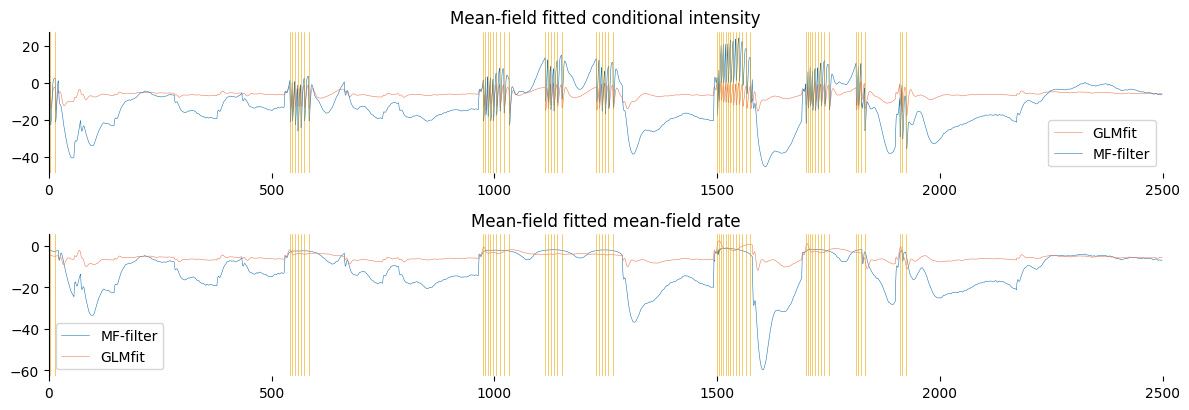

In [339]:
subplot(311)
plot(lograte(p0),lw=0.4,color=RUST,label='GLMfit')
plot(lograte(result),lw=0.4,label="MF-filter")
title('Mean-field fitted conditional intensity')
niceaxis()

subplot(312)
NLL,allM1 = filter_GLM(Bh,Y,result,ll_gain,ll_bias)
plot(logmean(allM1,result),lw=0.4,label="MF-filter")
plot(logmean(allM1_np,p0),lw=0.4,color=RUST,label='GLMfit')
title('Mean-field fitted mean-field rate')
niceaxis()

tight_layout()

figure()

def get_sample(p,M=100):
    m        = array(p).ravel()[0]
    beta     = ascolumn(p[1:K+1])
    beta_st  = ascolumn(p[1+K:])
    stim_np  = (m + Bh.dot(beta_st))[:,0]
    y,l = ensemble_sample(stim_np,B,beta,M=M)
    return y,l

y1,l1 = get_sample(p0,1000)
y2,l2 = get_sample(result,1000)

print('True   mean rate is',mean(Y))
print('GLMfit mean rate is',mean(y1))
print('MFfilt mean rate is',mean(y2))
print('GLMfit mean log-likelihood is',mean(Y[:,None]*l1 - sexp(l1)))
print('MFfilt mean log-likelihood is',mean(Y[:,None]*l2 - sexp(l2)))

# This is higher than it should be because we didn't correct for self-inhibition?
# Sample from original model
rate1 = exp(logmean(allM1_np,p0)).squeeze()
print('Mean-field mean-rate for GLMfit is',mean(rate1))

# This is lower than it should be becaus we didn't correct for self-excitation
# Sample from MF-filt fit model
rate2 = exp(logmean(allM1,result)).squeeze()
print('Mean-field mean-rate for MFfilt is',mean(rate2))

NSAMP = 50
subplot(411)
pcolormesh(-int32(y1[:,:NSAMP].T>0),cmap='gray')
noaxis(); 
xticks(arange(0,1001,100)); 
xlabel('Time (ms)'); 
ylabel('Sample',fontsize=9); 
niceaxis()
title('GLMfit')

subplot(412)
pcolormesh(-int32(y2[:,:NSAMP].T>0),cmap='gray')
noaxis(); 
xticks(arange(0,1001,100)); 
xlabel('Time (ms)'); 
ylabel('Sample',fontsize=9); 
xlim(STARTPLOT,STARTPLOT+NPLOT)
niceaxis()
title('MFfilt')
tight_layout()

# Optimize GLM using LNA without measurement updates

Incorporate estimate of fluctuations into likelihood

In [341]:
# (Keep input arguments, patameres, constants from the mean-field definitions)
# Limit variance corrections
maxvcorr = 100

beta = b.dimshuffle(['x',0])          # column
ateb = beta.T/(beta.T.dot(beta)[0,0]) # row

reg_1 = ateb.dot(T.eye(1)*1e-6).dot(ateb)
reg_2 = T.eye(K)*1e-6
reg_C = reg_2 + reg_2

# Additional constants for covariance evolution
Cop = Tcon(C)                        # Matrix
Cb  = Cop.dot(beta)                  # Matrix
CC  = Cop.dot(Cop.T)                 # Matrix

def LNA_ll(y,s,M1,M2):               # scalar, scalar, column, matrix
    m      = b.T.dot(M1)             # b:vector, M1:column, result:len-1 vector
    v      = b.T.dot(M2).dot(b)      # scalar
    v      = nozero(v)
    logr   = T.minimum(maxlogr,m+s)  # 1 vector
    R0     = Tsexp(logr)             # 1 vector
    vc     = 1+0.5*v
    vc     = T.minimum(maxvcorr,vc)  # scalar
    R1     = R0*vc                   # 1 vector
    ll     = y*logr-R1               # 1 vector
    return ll[0]                     # scalar

def integrate_LNA(M1,M2,s):          # column, matrix, scalar
    for j in range(oversample):
        logx = b.T.dot(M1)+s         # 1 vector
        R0   = Tsexp(logx)           # 1 vector
        R0   = T.minimum(maxrate,R0) # 1 vector
        R0  *= dtf                   # 1 vector
        M1  += Adt.dot(M1)           # Kx1 matrix (column) deterministic
        M1  += C*(R0)                # Kx1 matrix (column) spiking noise
        J    = Cb*R0+Adt             # KxK matrix
        JM2  = J.dot(M2)             # KxK matrix
        M2  += JM2 + JM2.T           # KxK matrix
        M2  += CC*R0                 # KxK matrix
    return M1,M2                     # column, matrix

def LNA_filter(y,s,nll,M1,M2):       # scalar, scalar, scalar, column, matrix
    M1,M2 = integrate_LNA(M1,M2,s)   # Kx1 matrix (column)
    ll    = LNA_ll(y,s,M1,M2)        # scalar
    ll    = ll*llgain+llbias         # scalar
    return nll-ll,M1,M2     # scalar, column, matrix

# Initial condition for second moment
M2 = T.eye(K,dtype=dtype)*1e-7

# Scan to compute moments, likelihood, measurement approximations
[cumnll_LNA, allM1_LNA, allM2_LNA], upLNA = theano.scan(LNA_filter,
                                                sequences     = [Ysp,stim],
                                                outputs_info  = [Tcon(0),M1,M2],
                                                non_sequences = [],
                                                n_steps       = N,
                                                name          = 'LNA_filter')
sumnll_LNA = cumnll_LNA[-1]

# GLM negative log-likelihood and history means
filter_LNA = Tfun(inp = [Xst,Ysp,par,llgain,llbias],
                  out = [sumnll_LNA,allM1_LNA, allM2_LNA],
                  upd = upLNA)

# GLM negative log-likelihood
NLL_LNA    = Tfun(inp = [Xst,Ysp,par,llgain,llbias], 
                  out = [sumnll_LNA],
                  upd = upLNA)

print('Defined LNA filtering GLM likelihood (no measurements)')

Defined LNA filtering GLM likelihood (no measurements)


### Illustrate LNA without measurement updates

(-20, 10)

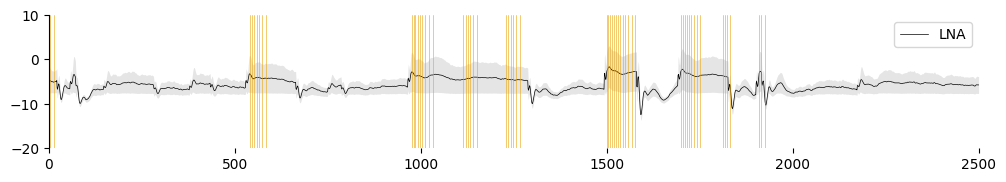

In [365]:
def logvar(allM1,allM2,pp):
    m       = array(pp).ravel()[0]
    beta    = ascolumn(pp[1:K+1])
    beta_st = ascolumn(pp[1+K:])
    return np.array([beta.T.dot(m2).dot(beta) for m2 in allM2]).ravel()

subplot(311)
nll ,allM1, allM2 = filter_LNA(Bh,Y,p0,ll_gain,ll_bias)
lm = logmean(allM1,p0)
lv = logvar(allM1,allM2,p0)
stderrplot(lm,lv,lw=0.5,label='LNA')
niceaxis()
ylim(-20,10)

### Gradients for LNA

In [343]:
grad_LNA = Tfun(inp = [Xst,Ysp,par,llgain,llbias], 
                out = [theano.gradient.jacobian(sumnll_LNA,par)],
                upd = upLNA)
print(grad_LNA)
print('(done)')

recalibrate_likelihood(NLL_LNA,grad_LNA,p0)
print(grad_LNA(Bh,Y,p0,ll_gain,ll_bias)[0])
print(numeric_grad(lambda x:NLL_LNA(Bh,Y,x,ll_gain,ll_bias),p0))

(done)
rescaled RMS gradient 50.0001
Shifted nll is  -2.3886561393737793e-05
[  4.87447691e+00  -2.02185440e+00  -1.51624739e+00   1.31756097e-01
   6.77120805e-01   7.21862912e-01   1.49188876e+00   4.13407230e+00
   4.46941185e+00   1.88210440e+00   1.17681885e+00  -1.04448109e+01
  -3.31003456e+01  -3.66156845e+01   2.54412994e+01   1.64450180e+02
   1.10400398e+02]
[  8.12848359e+00  -2.02627661e+00  -1.51223916e+00   1.70814043e-01
   7.73642524e-01   9.84427189e-01   2.07281631e+00   4.78629998e+00
   5.11967612e+00   1.42689228e+01   4.63792977e+01   8.68725243e+01
   1.64859397e+02   3.37783939e+02   6.89149091e+02   2.54150918e+03
   2.01845796e+03]


### Optimize GLM using LNA without measurement updates

In [357]:
x0 = p0 + randn(*p0.shape)*1e-4
result_LNA = x0

'''result_LNA = np.float128(['-5.26722577475', '-0.958476224094', '0.105001143274', '-1.3878277659', '-0.0530694634475', 
              '-1.15022127732', '-0.365875934645', '-0.0831215026589', '-0.50788907261', '-0.27615738965', 
              '0.721112129138', '-0.108877379667', '0.40652935799',  '-0.0195945097271', '0.174251749772', 
              '-0.161673313388', '-0.00141694765251'])
'''

result_LNA = [-5.7632510371,-0.694558984913,-0.365826544528,-4.80686708703,7.4369467517,-9.42028908679,7.119563688,-4.36419864785,0.734860845532,4.10351996955,-4.63602850103,3.91815160103,-1.97827248286,1.0536266355,-0.408518056414,0.141022673197,-0.0571683297285]

result_LNA = [-5.9082880366,-0.73193407386,-0.368048019254,-4.72408820063,7.43576560468,-9.46939441666,6.9198757086,-4.36632236796,0.668945083848,4.15128851375,-4.63347162332,3.90207045538,-1.95639635235,1.05582847329,-0.404315514029,0.148024458989,-0.0594086298297]

result_LNA = [-5.75926275329,-1.93504555723,0.389645810086,-4.06103323968,4.80955049052,-6.43743677629,4.35937131174,-3.21838662035,0.159402568812,4.44417794461,-4.48033625618,3.5044055644,-1.60090301317,0.993904308549,-0.544158672297,0.303170618085,-0.118989985737]

print('Set initial conditions')

Set initial conditions


In [358]:
strict    = False 
verbose   = False
tolerance = 1e-9
maxiter   = 1000
maxfev    = 1000
large     = sqrt(np.finfo('float32').max)

def objective_LNA(p):
    nll = NLL_LNA(Bh,Y,p,ll_gain,ll_bias)[0]
    if verbose:
        print('x=',v2str_long(p))
        print('nll =',np.float128(nll).astype(str))
    if not isfinite(nll):
        print('x=',v2str_long(p))
        print('nll =',np.float128(nll).astype(str))
        if strict:
            raise ArithmeticError('Invalid likelihood')
        else:
            nll = large
    return nll

def gradient_LNA(p):
    g = array(grad_LNA(Bh,Y,p,ll_gain,ll_bias)).ravel()
    if verbose:
        print('x=',v2str_long(p))
        print('∇=',v2str_long(g))
    if not all(isfinite(g)):
        print('x=',v2str_long(p))
        print('∇=',v2str_long(g))
        if strict:
            raise ArithmeticError('Invalid gradient')
        else:
            bad = ~isfinite(g)
            g[bad] = -large*sign[p[bad]]
    return g

def og_LNA(p):
    nll = objective_LNA(p)
    g   = gradient_LNA(p)
    return nll,g

print('Starting optimization')
#recalibrate_likelihood(NLL_LNA,grad_LNA,result_LNA)
#result_LNA = minimize_retry(og_LNA,result_LNA,jac=True,verbose=verbose,simplex_only=False)
recalibrate_likelihood(NLL_LNA,grad_LNA,result_LNA)
result_LNA = minimize_retry(objective_LNA,result_LNA,jac=False,verbose=verbose,simplex_only=True)
print("Finished optimization")
print('x=','['+','.join([np.float128(x).astype(str) for x in result_LNA])+']')

print("Total absolute change from GLM fit is",sum(abs(result_LNA-p0)))

Starting optimization
rescaled RMS gradient 49.9984
Shifted nll is  9.417533874511719e-06

                                                                                 
Finished optimization
x= [-5.75926275329,-1.93504555723,0.40912810059,-4.06103323968,4.80955049052,-6.43743677629,4.35937131174,-3.21838662035,0.159402568812,4.44417794461,-4.48033625618,3.5044055644,-1.60090301317,0.993904308549,-0.544158672297,0.303170618085,-0.118989985737]
Total absolute change from GLM fit is 41.1529721769


### Check that LNA filtering regression is close to GLMfit

True   mean rate is 0.0236
GLMfit mean rate is 0.0216992
LNAfilt mean rate is 0.0239484
GLMfit mean log-likelihood is -0.158350099584
LNAfilt mean log-likelihood is -0.0942238291767
Mean-field mean-rate for GLMfit is 0.072133372224
Mean-field mean-rate for LNAfilt is 0.0217961978637


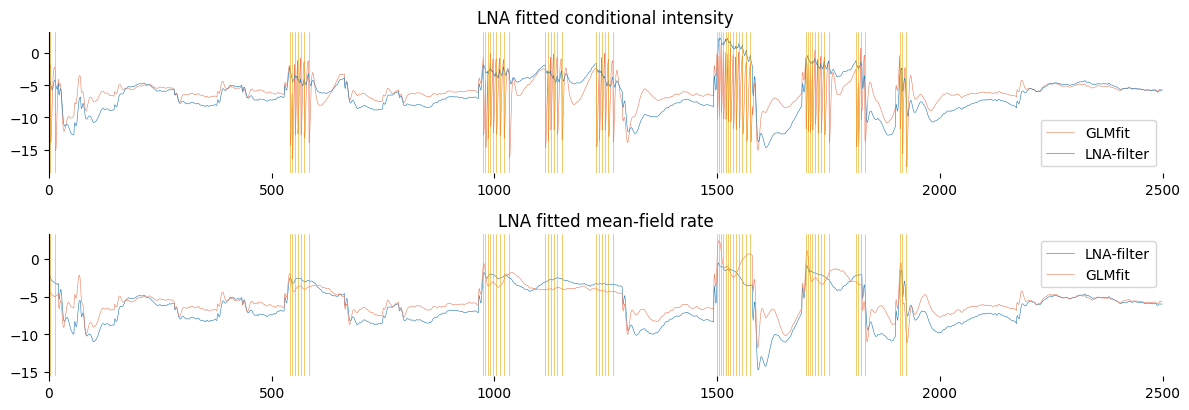

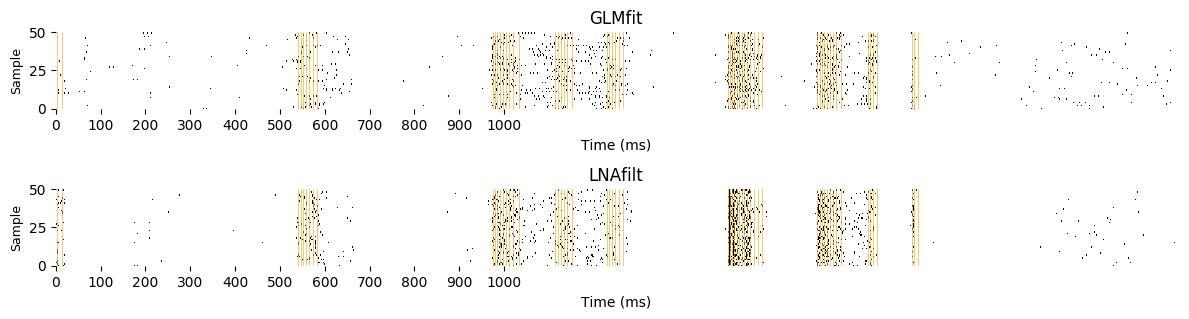

In [359]:
subplot(311)
plot(lograte(p0),lw=0.4,color=RUST,label='GLMfit')
plot(lograte(result_LNA),lw=0.4,label="LNA-filter")
title('LNA fitted conditional intensity')
niceaxis()

subplot(312)
NLL,allM1 = filter_GLM(Bh,Y,result_LNA,ll_gain,ll_bias)
plot(logmean(allM1,result_LNA),lw=0.4,label="LNA-filter")
plot(logmean(allM1_np,p0),lw=0.4,color=RUST,label='GLMfit')
title('LNA fitted mean-field rate')
niceaxis()

tight_layout()

y1,l1 = get_sample(p0,1000)
y2,l2 = get_sample(result_LNA,1000)

print('True   mean rate is',mean(Y))
print('GLMfit mean rate is',mean(y1))
print('LNAfilt mean rate is',mean(y2))
print('GLMfit mean log-likelihood is',mean(Y[:,None]*l1 - sexp(l1)))
print('LNAfilt mean log-likelihood is',mean(Y[:,None]*l2 - sexp(l2)))

# This is higher than it should be because we didn't correct for self-inhibition?
# Sample from original model
rate1 = exp(logmean(allM1_np,p0)).squeeze()
print('Mean-field mean-rate for GLMfit is',mean(rate1))

# This is lower than it should be becaus we didn't correct for self-excitation
# Sample from MF-filt fit model
rate2 = exp(logmean(allM1,result_LNA)).squeeze()
print('Mean-field mean-rate for LNAfilt is',mean(rate2))

figure()
NSAMP = 50
subplot(411)
pcolormesh(-int32(y1[:,:NSAMP].T>0),cmap='gray')
noaxis(); 
xticks(arange(0,1001,100)); 
xlabel('Time (ms)'); 
ylabel('Sample',fontsize=9); 
niceaxis()
title('GLMfit')
subplot(412)
pcolormesh(-int32(y2[:,:NSAMP].T>0),cmap='gray')
noaxis(); 
xticks(arange(0,1001,100)); 
xlabel('Time (ms)'); 
ylabel('Sample',fontsize=9); 
xlim(STARTPLOT,STARTPLOT+NPLOT)
niceaxis()
title('LNAfilt')
tight_layout()

(-20, 10)

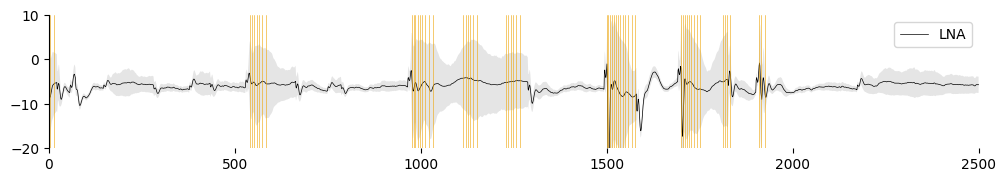

In [366]:
subplot(311)
nll ,allM1, allM2 = filter_LNA(Bh,Y,result_LNA,ll_gain,ll_bias)
lm = logmean(allM1,p0)
lv = logvar(allM1,allM2,p0)
stderrplot(lm,lv,lw=0.5,label='LNA')
niceaxis()
ylim(-20,10)

# Incorporate measurement updates into LNA filtering

So far, we have only been computing the likelihood against single-time marginals from mean-field and LNA approximations to the point process. This neglects autocorrelations to some extent. Measurement updates are the solution

In [466]:
# (Keep input arguments, patameres, constants from the mean-field and LNA definitions)
M2   = Tcon(np.eye(K)*1e-7)
Adt  = Tcon(A*dt)
beta = b.dimshuffle(['x',0])          # column
ateb = beta.T/(beta.T.dot(beta)[0,0]) # row
Cop  = Tcon(C)          # Matrix
Cb   = Cop.dot(beta)    # Matrix
CC   = Tcon(C.dot(C.T)) # Matrix

oversample = 1

# Initial condition for moments
M1 = Tcon(np.zeros((K,1)))
M2 = T.eye(K,dtype=dtype)*1e-7

maxlogr = 2

# Integration range
irange = T.constant(np.linspace(-3,3,10),dtype='float32') # vector

def intmoment(m,v,y,s,dt): # scalar scalar scalar scalar scalar
    m0,s0   = m,T.sqrt(v)                            # scalar scalar
    x       = irange*s0 + m0                         # vector
    logPx   = -0.5*(Tsdiv((x-m)**2,v)+Tslog(v*2*pi)) # vector
    lograte = x+s+Tslog(dt)                          # vector
    lograte = T.maximum(maxlogr,lograte)             # vector
    logPyx  = y*lograte-Tsexp(lograte)               # vector
    ll      = T.sum(logPyx*Tsexp(logPx))             # scalar
    logPyx -= T.max(logPyx)                          # vector
    Pxy     = Tsexp(logPyx+logPx)                    # vector
    norm    = T.sum(nozero(Pxy))                     # scalar
    m       = T.sum(x*Pxy)/norm                      # scalar
    v       = T.sum((x-m)**2*Pxy)/norm               # scalar
    return m,v,ll                                    # scalar scalar scalar

def gaussian_measurement(y,s,M1,M2): # scalar scalar column matrix
    m        = b.T.dot(M1)           # scalar
    m        = T.maximum(-30,T.minimum(0,m))
    v        = b.T.dot(M2).dot(b)    # scalar
    v        = nozero(v)
    v        = T.minimum(5,v)
    t        = Tsinv(v)              # scalar
    mp,vp,ll = intmoment(m,v,y,s,dt) # scalar scalar scalar
    mp       = T.maximum(-50,T.minimum(0,mp))
    vp       = T.minimum(5,vp)
    tp       = Tsinv(vp)             # scalar
    tr       = nozero(tp-t)          # scalar
    vr       = Tsinv(tr)             # scalar
    mr       = (mp*tp-m*t)*vr        # scalar
    M2b      = M2.dot(beta.T)        # column
    K        = Tsdiv(M2b,vr+v)       # column
    M2       = M2-K.dot(M2b.T)       # matrix
    M1       = M1+K*(mr-m)           # column 

    # try this instead?
    logr   = T.minimum(maxlogr,m+s)  # 1 vector
    R0     = Tsexp(logr)             # 1 vector
    vc     = 1+0.5*v
    vc     = T.minimum(maxvcorr,vc)  # scalar
    R1     = R0*vc                   # 1 vector
    ll     = (y*logr-R1)[0]          # scalar
    
    # Or just this?
    #logr   = T.minimum(maxlogr,m+s)  # 1 vector
    R0     = Tsexp(logr)             # 1 vector
    ll     = (y*logr-R0)[0]          # scalar
    
    return M1,M2,ll                  # column matrix scalar

def LNA_filter2(y,s,nll,M1,M2):   
    M1,M2    = integrate_LNA(M1,M2,s)
    M1,M2,ll = gaussian_measurement(y,s,M1,M2)
    ll = ll*llgain+llbias            # scalar
    return nll-ll,M1,M2  

# Scan to compute moments, likelihood, measurement approximations
[cumnll_LNA2, allM1_LNA2, allM2_LNA2], upLNA2 = theano.scan(LNA_filter2,
                                                    sequences     = [Ysp,stim],
                                                    outputs_info  = [Tcon(0),M1,M2],
                                                    non_sequences = [],
                                                    n_steps       = N,
                                                    name          = 'LNA_filter2')
sumnll_LNA2 = cumnll_LNA2[-1]

# GLM negative log-likelihood and history means
filter_LNA2 = Tfun(inp = [Xst,Ysp,par,llgain,llbias],
                  out  = [sumnll_LNA2,allM1_LNA2,allM2_LNA2],
                  upd  = upLNA2)

# GLM negative log-likelihood
NLL_LNA2    = Tfun(inp = [Xst,Ysp,par,llgain,llbias], 
                  out  = [sumnll_LNA2],
                  upd  = upLNA2)

print('LNA filter with measurement defined')

LNA filter with measurement defined


### Test the LNA filter

233.484375


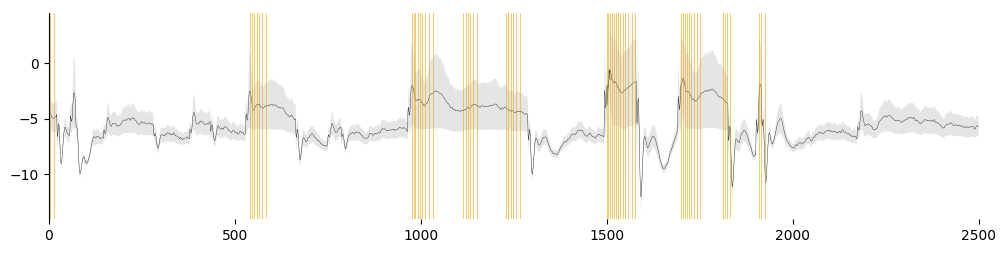

In [467]:
p1 = p0.copy()
p1[1:]*=1

nll_LNA2,allM1_LNA2,allM2_LNA2 = filter_LNA2(Bh,Y,p1,1,0)
print(nll_LNA2)

subplot(211)
lm = logmean(allM1_LNA2,p1)
lv = logvar (allM1_LNA2,allM2_LNA2,p1)
stderrplot(lm,lv,lw=0.25)
niceaxis()

### Gradients for LNA filtering with measurement

In [468]:
grad_LNA2 = Tfun(inp = [Xst,Ysp,par,llgain,llbias], 
                out = [theano.gradient.jacobian(sumnll_LNA2,par)],
                upd = upLNA2)
print(grad_LNA2)
print('(done)')

recalibrate_likelihood(NLL_LNA2,grad_LNA2,p0)
print(grad_LNA2(Bh,Y,p0,ll_gain,ll_bias)[0])
print(numeric_grad(lambda x:NLL_LNA2(Bh,Y,x,ll_gain,ll_bias),p0))

(done)
rescaled RMS gradient 49.9911
Shifted nll is  2.0712614059448242e-06
[ -9.36699867e+00   7.62883648e-02  -2.29436710e-01  -2.78895855e-01
  -3.69177818e-01  -8.28853130e-01  -1.11507344e+00  -4.52315301e-01
   2.13263873e-02  -2.43809547e+01  -4.73966484e+01  -7.26608582e+01
  -9.81492157e+01  -1.12213684e+02  -9.65560226e+01  -3.61078529e+01
  -3.77113457e+01]
[ -8.09915548e+00   8.06585505e-02  -1.85954257e-01  -2.04336209e-01
  -3.19717381e-01  -7.59446644e-01  -9.99145988e-01  -3.37942075e-01
   3.14214066e-02  -8.16446833e+00  -3.25270404e+00  -9.11790677e-01
              nan   1.36792034e+02              nan              nan
              nan]


In [469]:
x0 = p0 + randn(*p1.shape)*1e-9

'''result_LNA2 = x0
result_LNA2 =  [-4.53553980857,-35.436376398,-10.1000168412,3.70750785221,0.302154778674,-2.77495069808,
                1.24790738353,-1.90913637051,0.0225043553676,0.864764765216,-1.26636840571,1.48114282502,
                -0.996088263559,0.526319388745,-0.139387668409,-0.0164581590775,0.00599383754853]'''
''' [-5.61022494317,8.27404182385e-10,2.9664815132e-10,-3.59311243982e-10,9.64956913328e-10,-6.0288482003e-10,-2.41428291031e-10,-1.9512410342e-10,-2.52469616791e-11,6.19177339846e-11,7.81555499635e-10,1.7903572679e-09,-1.79299285966e-09,6.29776439274e-10,8.54727075857e-11,8.87159124655e-10,-1.09109977154e-09]'''

result_LNA2 = [-5.13048001067,-415.677466381,-58.6853534913,0.640717102487,0.289196327452,-1.1329032582,1.05792467917,-1.87960737134,0.00188514477745,0.27137708466,-1.00679392865,1.1763385601,-0.885005870205,0.366264407826,-0.0784877198932,-0.0042149027294,0.000947067564686]

result_LNA2 = [-6.3711051636,-533.547373746,-63.2488749151,0.671634495526,0.261015707365,-1.05631137572,0.84005698839,-1.90515676106,0.00173034013035,0.252625882765,-0.965267180984,1.88838447593,-0.722298349021,0.315590544524,-0.0893822561899,-0.00383353378557,0.000656080567056]

print(result_LNA2)
print('Set initial conditions')

[-6.3711051636, -533.547373746, -63.2488749151, 0.671634495526, 0.261015707365, -1.05631137572, 0.84005698839, -1.90515676106, 0.00173034013035, 0.252625882765, -0.965267180984, 1.88838447593, -0.722298349021, 0.315590544524, -0.0893822561899, -0.00383353378557, 0.000656080567056]
Set initial conditions


In [470]:
strict    = False 
verbose   = False
tolerance = 1e-9
maxiter   = 1000
maxfev    = 1000
large     = sqrt(np.finfo('float32').max)

def objective_LNA2(p):
    nll = NLL_LNA2(Bh,Y,p,ll_gain,ll_bias)[0]
    if verbose:
        print('x=',v2str_long(p))
        print('nll =',np.float128(nll).astype(str))
    if not isfinite(nll):
        if strict:
            raise ArithmeticError('Invalid likelihood')
        else:
            nll = large
    return nll

def gradient_LNA2(p):
    g = array(grad_LNA2(Bh,Y,p,ll_gain,ll_bias)).ravel()
    if verbose:
        print('x=',v2str_long(p))
        print('∇=',v2str_long(g))
    if not all(isfinite(g)):
        if strict:
            raise ArithmeticError('Invalid gradient')
        else:
            bad = ~isfinite(g)
            g[bad] = -large*sign(p[bad])
    return g

def og_LNA2(p):
    nll = objective_LNA2(p)
    g   = gradient_LNA2(p)
    return nll,g

print('Starting optimization')
#recalibrate_likelihood(NLL_LNA2,grad_LNA2,result_LNA2)
#result_LNA2 = minimize_retry(objective_LNA2,result_LNA2,jac=gradient_LNA2,verbose=verbose,simplex_only=False)
#recalibrate_likelihood(NLL_LNA2,grad_LNA2,result_LNA2)
#result_LNA2 = minimize_retry(og_LNA2,result_LNA2,jac=True,verbose=verbose,simplex_only=False)
recalibrate_likelihood(NLL_LNA2,grad_LNA2,result_LNA2)
result_LNA2 = minimize_retry(objective_LNA2,result_LNA2,jac=False,verbose=verbose,simplex_only=True)
print("Finished optimization")
print('x=','['+','.join([np.float128(x).astype(str) for x in result_LNA2])+']')

print("Total absolute change from GLM fit is",sum(abs(result_LNA2-p0)))

Starting optimization
rescaled RMS gradient 51.1741
Shifted nll is  5.796551704406738e-06

                                                                                 
Finished optimization
x= [-6.37111399357,-533.547702841,-63.2498154263,0.671706307588,0.26738094474,-1.05629523344,0.840130203837,-1.9054983906,0.00173070421964,0.252625830707,-0.965269639546,1.88838418045,-0.722299324619,0.315590116549,-0.0893615151163,-0.00383377174469,0.00065609112577]
Total absolute change from GLM fit is 614.816514929


### Check it!

True   mean rate is 0.0236
GLMfit mean rate is 0.0216548
LNAfilt mean rate is 0.0119728
GLMfit mean log-likelihood is -0.158193160214
LNAfilt mean log-likelihood is -1.29192413672
Mean-field mean-rate for GLMfit is 0.072133372224
Mean-field mean-rate for LNAfilt is 4010.98622613


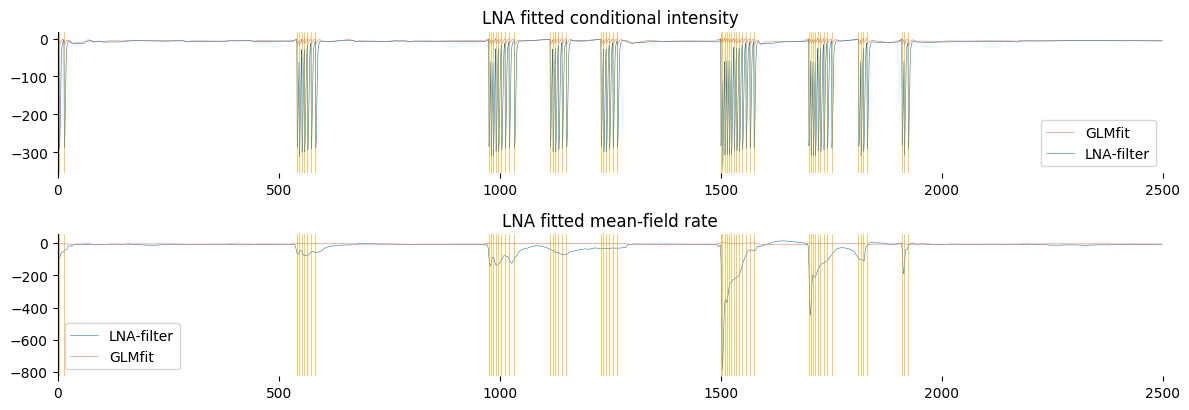

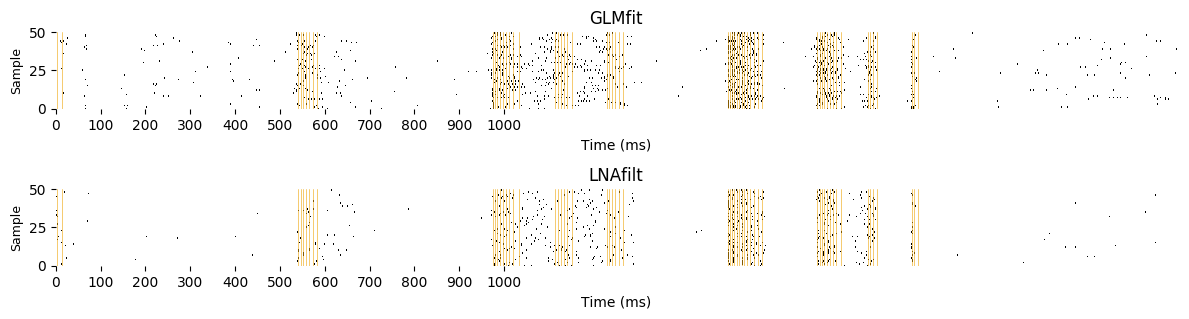

In [471]:
subplot(311)
plot(lograte(p0),lw=0.4,color=RUST,label='GLMfit')
plot(lograte(result_LNA2),lw=0.4,label="LNA-filter")
title('LNA fitted conditional intensity')
niceaxis()

subplot(312)
nll_LNA2,allM1_LNA2,allM2_LNA2 = filter_LNA2(Bh,Y,result_LNA2,ll_gain,ll_bias)
plot(logmean(allM1,result_LNA2),lw=0.4,label="LNA-filter")
plot(logmean(allM1_np,p0),lw=0.4,color=RUST,label='GLMfit')
title('LNA fitted mean-field rate')
niceaxis()

tight_layout()


y1,l1 = get_sample(p0,1000)
y2,l2 = get_sample(result_LNA2,1000)

print('True   mean rate is',mean(Y))
print('GLMfit mean rate is',mean(y1))
print('LNAfilt mean rate is',mean(y2))
print('GLMfit mean log-likelihood is',mean(Y[:,None]*l1 - sexp(l1)))
print('LNAfilt mean log-likelihood is',mean(Y[:,None]*l2 - sexp(l2)))

# This is higher than it should be because we didn't correct for self-inhibition?
# Sample from original model
rate1 = exp(logmean(allM1_np,p0)).squeeze()
print('Mean-field mean-rate for GLMfit is',mean(rate1))

# This is lower than it should be becaus we didn't correct for self-excitation
# Sample from MF-filt fit model
rate2 = exp(logmean(allM1,result_LNA2)).squeeze()
print('Mean-field mean-rate for LNAfilt is',mean(rate2))

figure()
NSAMP = 50
subplot(411)
pcolormesh(-int32(y1[:,:NSAMP].T>0),cmap='gray')
noaxis(); 
xticks(arange(0,1001,100)); 
xlabel('Time (ms)'); 
ylabel('Sample',fontsize=9); 
niceaxis()
title('GLMfit')
subplot(412)
pcolormesh(-int32(y2[:,:NSAMP].T>0),cmap='gray')
noaxis(); 
xticks(arange(0,1001,100)); 
xlabel('Time (ms)'); 
ylabel('Sample',fontsize=9); 
xlim(STARTPLOT,STARTPLOT+NPLOT)
niceaxis()
title('LNAfilt')
tight_layout()

# Second-order moment closure

In [622]:
# (Keep input arguments, patameres, constants from the mean-field and LNA definitions)
beta = b.dimshuffle(['x',0])          # column
ateb = beta.T/(beta.T.dot(beta)[0,0]) # row
Cop  = Tcon(C)          # Matrix
Cb   = Cop.dot(beta)    # Matrix
CC   = Tcon(C.dot(C.T)) # Matrix

# Initial condition for moments
M1 = Tcon(np.zeros((K,1)))
M2 = T.eye(K,dtype=dtype)*1e-7

# Integration range
irange = T.constant(np.linspace(-3,3,10),dtype='float32') # vector

def intmoment(m,v,y,s,dt): # scalar scalar scalar scalar scalar
    m0,s0   = m,T.sqrt(v)                            # scalar scalar
    x       = irange*s0 + m0                         # vector
    logPx   = -0.5*(Tsdiv((x-m)**2,v)+Tslog(v*2*pi)) # vector
    lograte = x+s+Tslog(dt)                          # vector
    lograte = T.maximum(maxlogr,lograte)             # vector
    logPyx  = y*lograte-Tsexp(lograte)               # vector
    ll      = T.sum(logPyx*Tsexp(logPx))             # scalar
    logPyx -= T.max(logPyx)                          # vector
    Pxy     = Tsexp(logPyx+logPx)                    # vector
    norm    = T.sum(nozero(Pxy))                     # scalar
    m       = T.sum(x*Pxy)/norm                      # scalar
    v       = T.sum((x-m)**2*Pxy)/norm               # scalar
    return m,v,ll                                    # scalar scalar scalar

def gaussian_measurement(y,s,M1,M2,dt): # scalar scalar column matrix
    m        = b.T.dot(M1)           # scalar
    m        = T.clip(m,-30,0)       # scalar
    v        = b.T.dot(M2).dot(b)    # scalar
    v        = T.clip(v,1e-3,5)      # scalar
    t        = Tsinv(v)              # scalar
    mp,vp,ll = intmoment(m,v,y,s,dt) # scalar scalar scalar
    mp       = T.clip(mp,-30,0)
    vp       = T.clip(vp,1e-3,5)
    tp       = Tsinv(vp)             # scalar
    tr       = nozero(tp-t)          # scalar
    vr       = Tsinv(tr)             # scalar
    mr       = (mp*tp-m*t)*vr        # scalar
    M2b      = M2.dot(beta.T)        # column
    K        = Tsdiv(M2b,vr+v)       # column
    M2       = M2-K.dot(M2b.T)       # matrix
    M1       = M1+K*(mr-m)           # column 
    '''
    # try this instead?
    logr   = T.minimum(maxlogr,m+s)  # 1 vector
    R0     = Tsexp(logr)             # 1 vector
    vc     = 1+0.5*v
    vc     = T.minimum(maxvcorr,vc)  # scalar
    R1     = R0*vc                   # 1 vector
    ll     = (y*logr-R1)[0]          # scalar
    '''
    # Or just this?
    logr   = T.minimum(maxlogr,m+s)  # 1 vector
    R0     = Tsexp(logr)             # 1 vector
    ll     = (y*logr-R0)[0]          # scalar
    
    return M1,M2,ll                  # column matrix scalar

def integrate_2ND(M1,M2,s):          # column, matrix, scalar
    logx = b.T.dot(M1)+s         # 1 vector
    R0   = Tsexp(logx)           # 1 vector
    R0   = T.minimum(maxrate,R0) # 1 vector
    R0  *= dtf                   # 1 vector
    M1  += Adt.dot(M1)           # Kx1 matrix (column) deterministic
    v    = b.T.dot(M2).dot(b)
    v    = T.clip(v,1e-3,5)      
    vc   = 1+0.5*v
    M1  += C*(R0*vc)             # Kx1 matrix (column) spiking noise
    J    = Cb*R0+Adt             # KxK matrix
    JM2  = J.dot(M2)             # KxK matrix
    M2  += JM2 + JM2.T           # KxK matrix
    M2  += CC*R0                 # KxK matrix
    return M1,M2                     # column, matrix


oversample = 1
mnr        = 0
mxr        = 2
mnlr       = -55
mxlr       = log(maxrate)
mnm        = -55
mxm        = mxlr
mnv        = 1e-6
mxv        = 10
dtf        = dt/oversample
Adt        = Tcon(A*dtf)
mnvc       = 1e-6
mxvc       = 10

def filter_2ND(y,s,nll,M1,M2): 
    ll = 0
    dy = y/oversample
    '''
    # projected moments
    m       = b.T.dot(M1)           # scalar
    m       = T.clip(m,mnm,mxm)     # scalar
    v       = b.T.dot(M2).dot(b)    # scalar
    v       = T.clip(v,mnv,mxv)     # scalar
    t       = Tsinv(v)              # scalar
    # univariate measurement 
    # likelihood 0: integrated
    mp,vp,l = intmoment(m,v,y,s,dtf)# scalar scalar scalar
    mp      = T.clip(mp,mnm,mxm)
    vp      = T.clip(vp,mnv,mxv)
    tp      = Tsinv(vp)             # scalar
    # log-rate and rate
    lr      = m+s                   # 1 vector
    lr      = T.clip(lr,mnlr,mxlr)  # 1 vector
    lr     += T.log(dt)
    R0      = Tsexp(lr)             # 1 vector
    R0      = T.clip(R0,mnr,mxr)    # 1 vector
    # variance correction
    vc      = 1+0.5*v               # scalar
    R1      = R0*vc                 # 1 vector
    # likelihood 1: point
    #l       = (y*lr-R0)[0]         # scalar
    # likelihood 2: moment 
    #ll     = (y*lr-R1)[0]          # scalar
    # likelihood 3: gaussian at posterior mean
    # P(y) ~ P(y|x)*P(x)/P(x|y)
    #lr      = mp + s + T.log(dt)
    #lpyx    = (y*lr-Tsexp(lr))
    #dkl     =  0.5*(Tslog(v)-Tslog(vp)+Tsdiv((mp-m)**2,v))
    lpxy    = -0.5*Tslog(2*pi*vp)
    lpx     = -0.5*Tslog(2*pi*v) + -0.5*Tsdiv((m-mp)**2,vp)
    #l       = (lpyx-dkl)[0]
    # likelihood 4: gaussian at prior mean
    lr      = m + s + T.log(dt)
    lpyx    = (y*lr-Tsexp(lr))
    lpx     = -0.5*Tslog(2*pi*v)
    lpxy    = -0.5*Tslog(2*pi*vp) + -0.5*Tsdiv((m-mp)**2,v)
    l       = (lpyx+lpx-lpxy)[0]
    ll     += l
    '''
    for j in range(oversample):
        # projected moments
        m       = b.T.dot(M1)           # scalar
        m       = T.clip(m,mnm,mxm)     # scalar
        v       = b.T.dot(M2).dot(b)    # scalar
        v       = T.clip(v,mnv,mxv)     # scalar
        t       = Tsinv(v)              # scalar
        # univariate measurement 
        # likelihood 0: integrated
        mp,vp,l = intmoment(m,v,dy,s,dtf)# scalar scalar scalar
        mp      = T.clip(mp,mnm,mxm)
        vp      = T.clip(vp,mnv,mxv)
        tp      = Tsinv(vp)             # scalar
        # log-rate and rate
        lr      = m+s                   # 1 vector
        lr      = T.clip(lr,mnlr,mxlr)  # 1 vector
        lr     += T.log(dtf)
        R0      = Tsexp(lr)             # 1 vector
        R0      = T.clip(R0,mnr*dtf,mxr*dtf) # 1 vector
        # variance correction
        vc      = exp(0.5*v)#1+0.5*v               # scalar
        vc      = T.clip(vc,mnvc,mxvc)
        R1      = R0*vc                 # 1 vector
        R1      = T.clip(R1,mnr*dtf,mxr*dtf)
        # likelihood 1: point
        #l       = (dy*lr-R0)[0]         # scalar
        # likelihood 2: moment 
        #l      = (dy*lr-R1)[0]          # scalar
        # likelihood 3: gaussian at posterior mean
        # P(y) ~ P(y|x)*P(x)/P(x|y)
        '''
        lrp     = T.clip(mp+s,mnlr,mxlr) + T.log(dtf)
        lpyx    = (dy*lrp-Tsexp(lrp))
        lpxy    = -0.5*Tslog(2*pi*vp)
        lpx     = -0.5*Tslog(2*pi*v) + -0.5*Tsdiv((m-mp)**2,v)
        l       = (lpyx+lpx-lpxy)[0]
        '''
        # likelihood 4: gaussian at prior mean
        # P(y) ~ P(y|x)*P(x)/P(x|y)
        lpyx    = (dy*lr-Tsexp(lr))
        lpx     = -0.5*Tslog(2*pi*v)
        lpxy    = -0.5*Tslog(2*pi*vp) + -0.5*Tsdiv((m-mp)**2,vp)
        l       = (lpyx+lpx-lpxy)[0]
        
        # Another way to get R1?
        #R1 = dy*lr-l
        #R1 = T.clip(R1,mnr*dtf,mxr*dtf)
        
        ll     += l
        # surrogate likelihood
        tr      = nozero(tp-t)          # scalar
        vr      = Tsinv(tr)             # scalar
        mr      = (mp*tp-m*t)*vr        # scalar
        mr      = T.clip(mr,mnm,mxm)
        vr      = T.clip(vr,mnv,mxv)
        # conditional MVG update
        M2b     = M2.dot(beta.T)        # column
        K       = Tsdiv(M2b,vr+v)       # column
        M2      = M2-K.dot(M2b.T)       # matrix
        M1      = M1+K*(mr-m)           # column 
        # moment updates
        M1     += Adt.dot(M1)           # Kx1 matrix (column) deterministic
        M1     += C*R1                  # Kx1 matrix (column) spiking noise
        J       = Cb*R0+Adt             # KxK matrix
        JM2     = J.dot(M2)             # KxK matrix
        M2     += JM2 + JM2.T           # KxK matrix
        M2     += CC*R1                 # KxK matrix
    ll = ll*llgain+llbias               # scalar
    return nll-ll,M1,M2  

# Scan to compute moments, likelihood, measurement approximations
[cumnll_2ND, allM1_2ND, allM2_2ND], up2ND = theano.scan(filter_2ND,
                                                    sequences     = [Ysp,stim],
                                                    outputs_info  = [Tcon(0),M1,M2],
                                                    non_sequences = [],
                                                    n_steps       = N,
                                                    name          = 'filter_2ND')
sumnll_2ND = cumnll_2ND[-1]

# GLM negative log-likelihood and history means
filter_2ND = Tfun(inp = [Xst,Ysp,par,llgain,llbias],
                  out  = [sumnll_2ND,allM1_2ND,allM2_2ND],
                  upd  = up2ND)

# GLM negative log-likelihood
NLL_2ND    = Tfun(inp = [Xst,Ysp,par,llgain,llbias], 
                  out  = [sumnll_2ND],
                  upd  = up2ND)

print('Second order filter with measurement defined')

INFO (theano.gof.compilelock): Refreshing lock /home/mrule/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir/lock


Second order filter with measurement defined


301.09259033203125


(-10, 0)

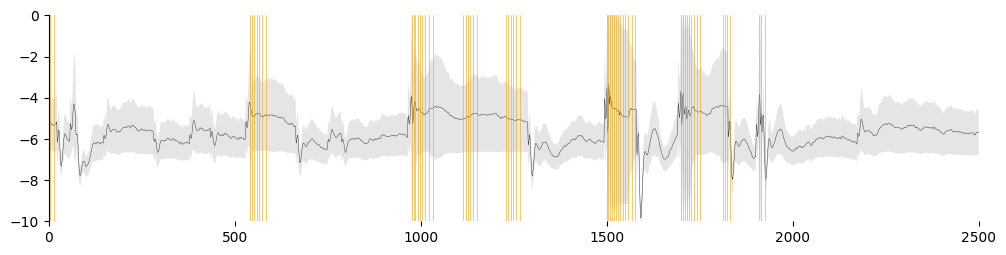

In [624]:
p1 = p0.copy()
p1[1:]*=0.5
nll_2ND,allM1_2ND,allM2_2ND = filter_2ND(Bh,Y,p1,1,0)
print(nll_2ND)
subplot(211)
lm = logmean(allM1_2ND,p1)
lv = logvar (allM1_2ND,allM2_2ND,p1)
stderrplot(lm,lv,lw=0.25)
niceaxis()
ylim(-10,0)

In [625]:
p1 = p0.copy()
p1[1:]*=0.5
x0 = p1 + randn(*p1.shape)*1e-9
result_2ND = x0

'''result_2ND = x0
result_2ND =  [-4.53553980857,-35.436376398,-10.1000168412,3.70750785221,0.302154778674,-2.77495069808,
                1.24790738353,-1.90913637051,0.0225043553676,0.864764765216,-1.26636840571,1.48114282502,
                -0.996088263559,0.526319388745,-0.139387668409,-0.0164581590775,0.00599383754853]'''
''' [-5.61022494317,8.27404182385e-10,2.9664815132e-10,-3.59311243982e-10,9.64956913328e-10,-6.0288482003e-10,-2.41428291031e-10,-1.9512410342e-10,-2.52469616791e-11,6.19177339846e-11,7.81555499635e-10,1.7903572679e-09,-1.79299285966e-09,6.29776439274e-10,8.54727075857e-11,8.87159124655e-10,-1.09109977154e-09]'''
'''
result_2ND = [-5.13048001067,-415.677466381,-58.6853534913,0.640717102487,0.289196327452,-1.1329032582,1.05792467917,-1.87960737134,0.00188514477745,0.27137708466,-1.00679392865,1.1763385601,-0.885005870205,0.366264407826,-0.0784877198932,-0.0042149027294,0.000947067564686]
result_2ND = [-6.3711051636,-533.547373746,-63.2488749151,0.671634495526,0.261015707365,-1.05631137572,0.84005698839,-1.90515676106,0.00173034013035,0.252625882765,-0.965267180984,1.88838447593,-0.722298349021,0.315590544524,-0.0893822561899,-0.00383353378557,0.000656080567056]
result_2ND = [-6.32073443283,-529.809544604,-61.7587541589,0.675152332344,0.26426130497,-1.06413478771,0.84781488834,-1.91492647188,0.00175089843313,0.255910970625,-0.95940083702,1.89007879241,-0.722092970064,0.316868053092,-0.0890176508407,-0.00387534066827,0.000660645543481]
'''

#result_2ND =  [-5.43162804492,-571.708831348,-66.2875445888,0.701551340968,0.242166133938,-1.07866171916,0.913775086156,-1.93349055936,0.0018026120004,0.242277583707,-1.06062782385,1.69293329864,-0.645696170203,0.344691373584,-0.0862146637981,-0.00394170162424,0.000699250245375]

print(result_2ND)
print('Set initial conditions')

[ -5.61022494 -11.47515355  -1.48525303  -0.89471006   5.04011275
  -4.20043037   3.33484275  -2.6707528    0.71962339   2.28132508
  -2.36047281   1.9733123   -1.01487213   0.4304688   -0.27207406
   0.15810169  -0.05254635]
Set initial conditions


In [626]:
strict    = False 
verbose   = False
large     = sqrt(np.finfo('float32').max)
def objective_2ND(p):
    nll = NLL_2ND(Bh,Y,p,ll_gain,ll_bias)[0]
    if verbose:
        print('x=',v2str_long(p))
        print('nll =',np.float128(nll).astype(str))
    if not isfinite(nll):
        if strict:
            raise ArithmeticError('Invalid likelihood')
        else:
            nll = large
    return nll

print('Starting optimization')
recalibrate_likelihood(NLL_2ND,grad_2ND,result_2ND)
result_2ND = minimize_retry(objective_2ND,result_2ND,jac=False,verbose=verbose,simplex_only=True,tol=1e-12)
print("Finished optimization")
print('x=','['+','.join([np.float128(x).astype(str) for x in result_2ND])+']')

print("Total absolute change from GLM fit is",sum(abs(result_2ND-p0)))

Starting optimization
rescaled RMS gradient 50.0
Shifted nll is  -3.0994415283203125e-06

                                                                                 
Finished optimization
x= [-5.59530370448,-10.9605591712,-1.47330742998,-0.881609943218,5.22386445739,-4.17463793047,3.44203651347,-2.6655660538,0.718776279434,2.2926495615,-2.31539042848,1.98075643314,-0.954066915012,0.443866676867,-0.270577429475,0.163180513758,-0.0577621245392]
Total absolute change from GLM fit is 38.7244172392


True   mean rate is 0.0236
GLMfit mean rate is 0.0215132
2NDfilt mean rate is 0.0163396
GLMfit mean log-likelihood is -0.158824155859
2NDfilt mean log-likelihood is -0.110270528206
Mean-field mean-rate for GLMfit is 0.072133372224
Mean-field mean-rate for 2NDfilt is 0.00629619274899


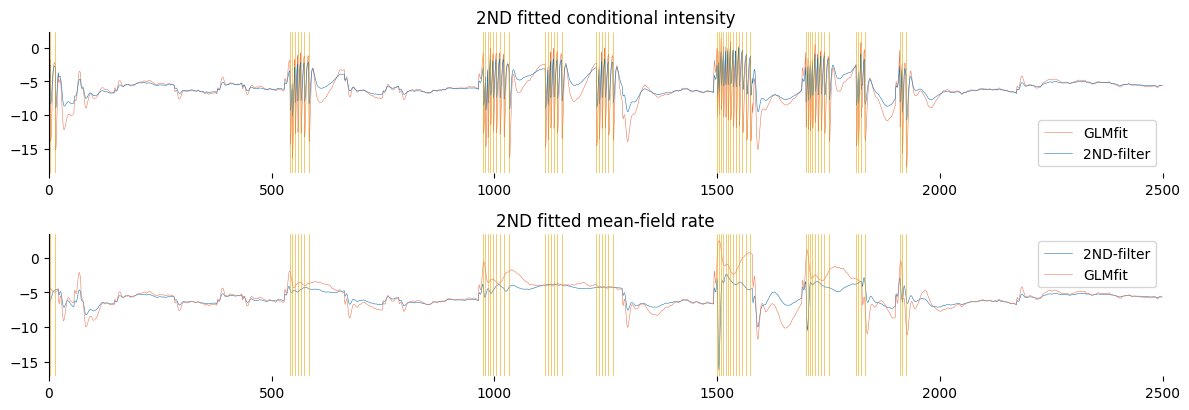

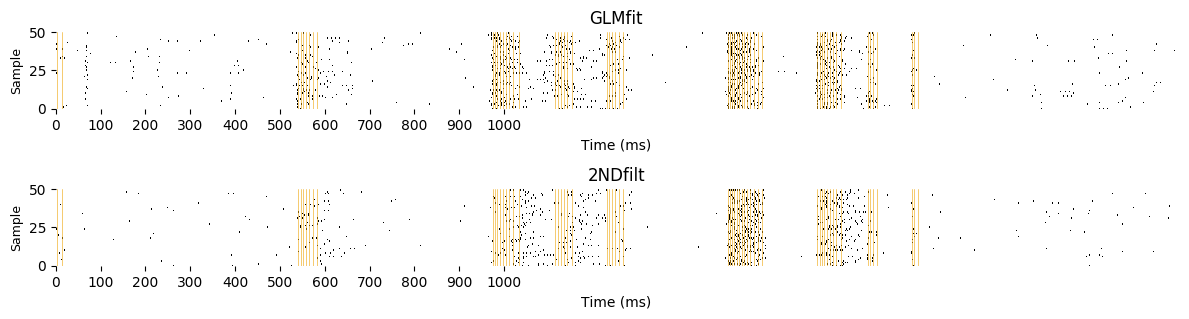

In [628]:
subplot(311)
plot(lograte(p0),lw=0.4,color=RUST,label='GLMfit')
plot(lograte(result_2ND),lw=0.4,label="2ND-filter")
title('2ND fitted conditional intensity')
niceaxis()

subplot(312)
nll_2ND,allM1_2ND,allM2_2ND = filter_2ND(Bh,Y,result_2ND,ll_gain,ll_bias)
plot(logmean(allM1,result_2ND),lw=0.4,label="2ND-filter")
plot(logmean(allM1_np,p0),lw=0.4,color=RUST,label='GLMfit')
title('2ND fitted mean-field rate')
niceaxis()

tight_layout()

# Sample from point-process models
y1,l1 = get_sample(p0,1000)
y2,l2 = get_sample(result_2ND,1000)

print('True   mean rate is',mean(Y))
print('GLMfit mean rate is',mean(y1))
print('2NDfilt mean rate is',mean(y2))
print('GLMfit mean log-likelihood is',mean(Y[:,None]*l1 - sexp(l1)))
print('2NDfilt mean log-likelihood is',mean(Y[:,None]*l2 - sexp(l2)))

# This is higher than it should be because we didn't correct for self-inhibition?
# Sample from original model
rate1 = exp(logmean(allM1_np,p0)).squeeze()
print('Mean-field mean-rate for GLMfit is',mean(rate1))

# This is lower than it should be becaus we didn't correct for self-excitation
# Sample from MF-filt fit model
rate2 = exp(logmean(allM1,result_2ND)).squeeze()
print('Mean-field mean-rate for 2NDfilt is',mean(rate2))

figure()
NSAMP = 50
subplot(411)
pcolormesh(-int32(y1[:,:NSAMP].T>0),cmap='gray')
noaxis(); 
xticks(arange(0,1001,100)); 
xlabel('Time (ms)'); 
ylabel('Sample',fontsize=9); 
niceaxis()
title('GLMfit')
subplot(412)
pcolormesh(-int32(y2[:,:NSAMP].T>0),cmap='gray')
noaxis(); 
xticks(arange(0,1001,100)); 
xlabel('Time (ms)'); 
ylabel('Sample',fontsize=9); 
xlim(STARTPLOT,STARTPLOT+NPLOT)
niceaxis()
title('2NDfilt')
tight_layout()

(-20, 0)

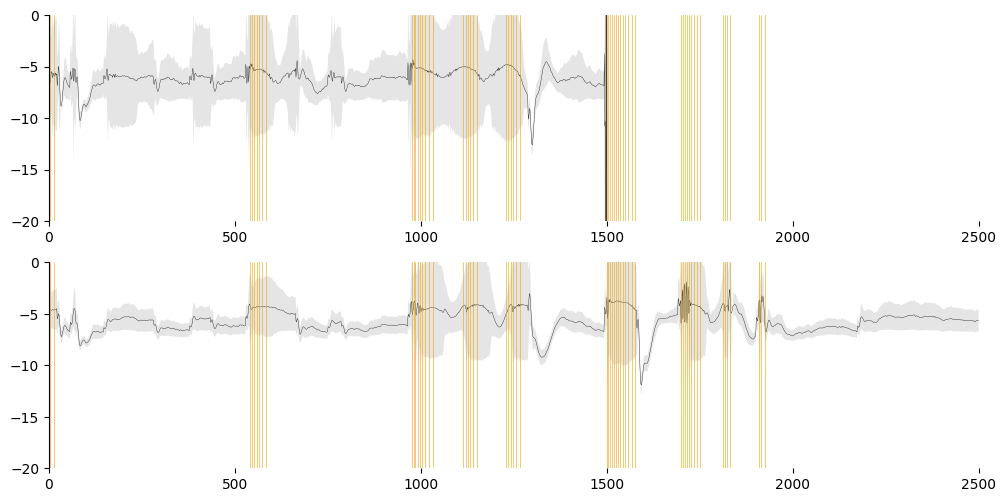

In [635]:
subplot(211)
nll_2ND,allM1_2ND,allM2_2ND = filter_2ND(Bh,Y,p0,1,0)
lm = logmean(allM1_2ND,p1)
lv = logvar (allM1_2ND,allM2_2ND,p1)
stderrplot(lm,lv,lw=0.25)
niceaxis()
ylim(-20,0)

subplot(212)
nll_2ND,allM1_2ND,allM2_2ND = filter_2ND(Bh,Y,result_2ND,1,0)
lm = logmean(allM1_2ND,result_2ND)
lv = logvar (allM1_2ND,allM2_2ND,result_2ND)
stderrplot(lm,lv,lw=0.25)
niceaxis()
ylim(-20,0)


# Theano filter likelihood integrator

We need to define a recursive filtering function, then we will try to get gradients via backpropagation through time. 
We cannot accurately backpropagatin through the non-conjugate measurement update, so we define two passes. The first pass computes surrogate Gaussian measurements, which are conjugate, and approximate the true Poisson measurements. The second pass uses these surrogate measurements, and (hopefully!) will be stable enough to get a gradient. 

## Part 1: filter to compute surrogate measurements

In [ ]:
# Input arguments
#dtype = 'float64'
#Xst  = T.matrix("Xst",dtype=dtype) # stimulus history features
#Ysp  = T.vector("Ysp",dtype=dtype) # spikes
#par  = T.col("par",dtype=dtype) # packed parameter vectors


Cb  = C.dot(b.T) # if b is a vector, Cb will be a vector
CC  = C.dot(C.T)
meanrate     = np.mean(Y)
rate_penalty = 500
reg_cov      = 1e-6
prior_prec   = 1e-8

b    = par[1:K+1,:] # spike history weights
mm   = par[0,0]

# Pre-compute projected stimulus
stim = mm + Xst.dot(par[K+1:,:])

# Hard-coded parameters
oversample   = 5
dt           = T.constant(1      ,dtype=dtype)
meanrate     = T.constant(np.mean(Y),dtype=dtype)

maxlogr      = T.constant(1      ,dtype=dtype)
maxrate      = T.constant(2      ,dtype=dtype)

eps          = T.constant(np.finfo(dtype).eps  ,dtype=dtype)
rate_penalty = T.constant(500    ,dtype=dtype)
reg_cov      = T.constant(1e-6   ,dtype=dtype)
prior_prec   = T.constant(1e-8   ,dtype=dtype)

# Constants
dtf = dt/oversample
Cb  = C.dot(b.T)
CC  = C.dot(C.T)
Adt = A*dtf

In [ ]:
def update_moment_theano(m,v,y,s,dt):
    # Get moments by integrating
    # Construct range for integration
    m0,s0 = m,T.sqrt(v) 
    x = T.constant(np.linspace(-4,4,100),dtype='float32')*s0+m0
    # Calculate likelihood contribution
    lograte = x+s+Tslog(dt)
    l  = y*(lograte)-Tsexp(lograte)
    # Normalize to prevent overflow
    offset = T.max(l)
    l -= offset
    # Calculate prior contribution
    l += -0.5*(  Tsdiv((x-m)**2,v) + Tslog(v) + Tslog(2*pi) )
    # Estimate posterior
    p  = Tsexp(l)*Tsexp(offset)
    py = nozero(T.sum(p))
    p /= py
    # Integrate to get posterior moments
    m  = T.sum(x*p)
    v  = T.sum((x-m)**2*p)
    return m,v#,Tslog(py)

In [ ]:
def measurement_update(y,s,M1,M2):
    '''
    (mr,tr): `surrogate` Gaussian approximation to likelihood
    '''
    # Gaussian prior on log-rate
    M2b    = M2.dot(b)
    v      = nozero(b.T.dot(M2b))
    m      = b.T.dot(M1)
    t      = Tsinv(v)
    # Regularizing Gaussian prior on log-rate
    tq     = prior_prec + t
    vq     = Tsinv(tq)
    mq     = (m*t+mm*prior_prec)*vq
    m,v,t  = mq,vq,tq
    # Integrate to get posterior moments (cannot differentite this)
    mp,vp  = update_moment_theano(m,v,y,s,dt)
    tp     = Tsinv(vp)
    # Generate surrogate univariate likelihood
    tr     = nozero(tp-t)
    vr     = Tsinv(tr)
    mr     = (mp*tp-m*t)*vr
    # Optimized Kalman update using surrogate univariate likelihood
    K      = Tsdiv(M2b,vr+v)
    M2     = M2-K.dot(M2b.T)
    M1     = M1+K*(mr-m)
    # Compute log-likelihood from univariate log-rate update
    logr   = T.minimum(maxlogr,mp+s)
    logPyx = y*logr-Tsexp(logr)
    DklQP  = 0.5*(Tslog(v)-Tslog(vp)+Tsdiv((mp-m)**2,v))
    ll     = logPyx #- DklQP
    ll     = ll[0,0]
    return M1,M2,ll,mr,tr

In [ ]:
def integrate_moments(M1,M2,s):
    for j in range(oversample):
        logv = b.T.dot(M2).dot(b)
        logx = b.T.dot(M1)+s
        R0   = Tsexp(logx)
        R0   = T.minimum(maxrate,R0)
        R0   = R0*dtf
        Rm   = R0*(1+0.5*logv)
        Rm   = T.minimum(maxrate,Rm)
        M1  += Adt.dot(M1) +  C*Rm
        J    = Cb*R0+Adt
        M2  += J.dot(M2) + M2.dot(J.T) + CC*Rm
    return M1,M2
    

In [ ]:
# Initial condition for moments
M1 = T.zeros((K,1),dtype=dtype)
M2 = T.eye(K,dtype=dtype)*eps

def filterer(y,s,nll,M1,M2):
    # Integrate
    #M1,M2 = integrate_moments(M1,M2,s)
    # Regularize
    #M2 = 0.5*(M2+M2.T)+reg_cov*T.eye(K)
    # Measurement update
    #M1,M2,ll,mr,tr = measurement_update(y,s,M1,M2)
    #ll,mr,tr = 1,1,1
    #return nll-ll/float(N),M1,M2,mr,tr
    return 1.,M1,M2,1.,1.

In [ ]:
# Scan to compute moments, likelihood, measurement approximations
[cumnll,allM1,allM2,allmr,alltr], updates = theano.scan(filterer,
                                            sequences     = [Ysp,stim],
                                            outputs_info  = [
                                                T.constant(0.0,dtype='float64'),
                                                M1,M2,None,None],
                                            non_sequences = [],
                                            n_steps       = N,
                                            name          = 'filterscanner')